# Predicting Stock Prices Using Time Series Analysis 
### $BF-B

In [2]:
# Importing required packages
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
#import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import dates
%matplotlib inline

In the following cell, we choose the date range for our analysis. I'd prefer to do 10 years for the larger sample, but to keep it simple for the first analysis we'll do 5 years

If I could install the yfinance package on my computer, I would use it but for this analysis I downloaded the data from Yahoo as a csv file. For future projects I will hopefully have yfinance as it makes it much easier, especially for comparative and stock portfolio analyses

In [4]:
# This is the code I would use if yfinance worked for the range of 5 years
end = dt.datetime.today()
start = (end - dt.timedelta(days = (365*5)))
print('Starting Date : ', start, '/nEnding Date :', end)

Starting Date :  2018-10-28 21:05:50.721541 /nEnding Date : 2023-10-27 21:05:50.721541


I import the data using pandas. The company I chose to analyze is Brown-Forman. My senior capstone project was a strategic analysis paper comparing two companies and I chose Brown-Forman as my "strong performer." Almost a year has passed since writing that paper and I was curious to forecast $BF-B's stock performance.

In [3]:
df_bf = pd.read_csv('BF-B.csv')
df_bf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/29/18,47.130001,47.590000,45.689999,46.189999,43.083282,2652000
1,10/30/18,46.340000,46.570000,45.820000,46.520000,43.391090,1338400
2,10/31/18,46.840000,47.310001,46.290001,46.340000,43.223194,1930200
3,11/1/18,46.430000,47.480000,46.419998,47.150002,43.978725,1796000
4,11/2/18,47.220001,48.270000,47.070000,47.250000,44.071999,1397700


To plot the data, I use the matplotlib package. Python doesn't have the strongest visualization tools - for larger projects, Tableau is my data viz software of choice.

For better visibility, only the close and adjusted close prices are shown

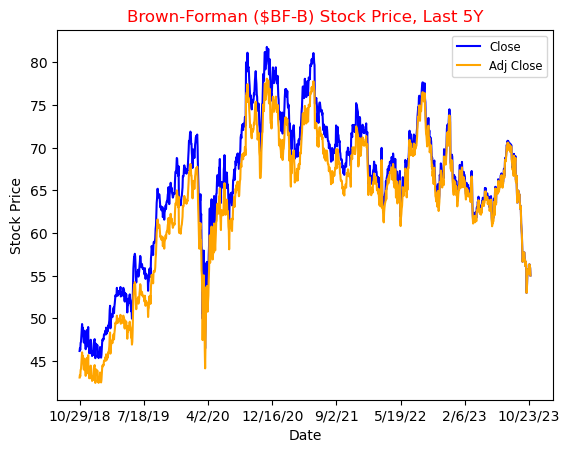

In [46]:
plt.plot(df_bf['Date'], df_bf['Close'], label = 'Close', color = 'blue')
plt.plot(df_bf['Date'], df_bf['Adj Close'], label = 'Adj Close', color = 'orange')
plt.legend(fontsize = 'small', loc = 'upper right')
plt.title('Brown-Forman ($BF-B) Stock Price, Last 5Y', color = 'red')
plt.xticks(df_bf['Date'][::179])
# indexed by 179 because there are 1258 dates in the set and indexing by 179 allows the max # of dates to be legible on x-axis
# much easier to do with yfinance package + other viz software
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

Looking at this viz we get a feel for the trend of $BF-B over the past 5 years. Another way to look at the trend is to analyze the stock's daily returns over that timeframe.

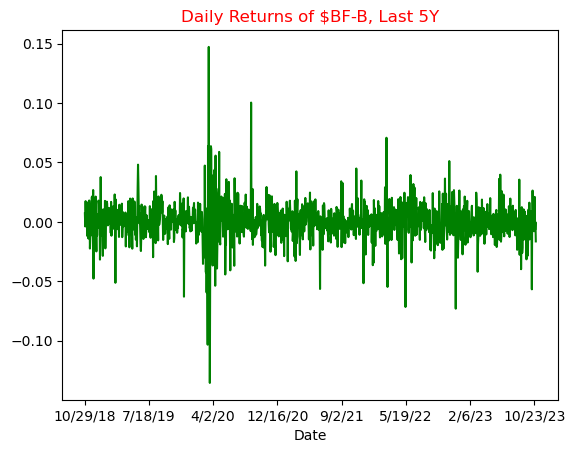

In [53]:
daily_return = df_bf['Adj Close'].pct_change()
# using adjusted close because it accounts for dividends, stock splits and dilution
plt.plot(df_bf['Date'], daily_return, color = 'green')
plt.title('Daily Returns of $BF-B, Last 5Y', color = 'red')
plt.xticks(df_bf['Date'][::179])
plt.xlabel('Date')
plt.show()

# Forecasting - The Prophet Model

As a brief summary, the Prophet Model (https://facebook.github.io/prophet/) is a procedure for forecasting time series data created by Facebook (Meta). It works best with time series that have strong seasonal effects and several seasons of historical data. This is why I would prefer to have more than 5 years of stock price data, but we can test the data before creating the model to see if it qualifies.

In [55]:
# Quick look at the data to make sure everything looks right
df_bf

,Date,Open,High,Low,Close,Adj Close,Volume
0,10/29/18,47.130001,47.590000,45.689999,46.189999,43.083282,2652000
1,10/30/18,46.340000,46.570000,45.820000,46.520000,43.391090,1338400
2,10/31/18,46.840000,47.310001,46.290001,46.340000,43.223194,1930200
3,11/1/18,46.430000,47.480000,46.419998,47.150002,43.978725,1796000
4,11/2/18,47.220001,48.270000,47.070000,47.250000,44.071999,1397700
...,...,...,...,...,...,...,...
1253,10/23/23,54.990002,55.790001,54.660000,55.189999,55.189999,1387800
1254,10/24/23,55.570000,56.799999,55.570000,56.349998,56.349998,1542000
1255,10/25/23,56.189999,56.570000,55.669998,55.970001,55.970001,1143100
1256,10/26/23,56.419998,56.939999,55.910000,55.959999,55.959999,1372100


Because we are trying to predict the price of the stock itself, the only columns we really need are date and close. The date is our "datestamp" and the close is our "dependent variable" that we want to predict based on the date. We can query this dataset to only include our required inputs.

In [56]:
df = df_bf[['Date', 'Close']]
df.head()

,Date,Close
0,10/29/18,46.189999
1,10/30/18,46.520000
2,10/31/18,46.340000
3,11/1/18,47.150002
4,11/2/18,47.250000


### Durbin Watson Test

The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical model. DW will always be between 0 and 4. Values from 0 to 2 indicate positive autocorrelation and values from 2 to 4 indicate negative autocorrelation, while a value of exactly 2 means no autocorrelation was detected. A general rule followed is: DW test statistic values in the range of 1.5 to 2.5 are relatively acceptable.

Because we are looking at time series data, we want there to be autocorrelation.

The application of this to stock prices is practical. If the stock price has positive autocorrelation, that indicates the price yesterday has a positive correlation on the price today, so if the stock dropped today, it's likely the stock falls tomorrow. On the other hand, a stock price with a negative autocorrelation means that if its price fell yesterday, there is a greater likelihood that it will rise today.

In [57]:
import statsmodels.api as sm
dw_test = sm.stats.durbin_watson(df['Close'])
print('The value of the Durbin Watson statistic is', dw_test)
if abs(dw_test)<= 1.5 or abs(dw_test)>= 2.5:
    print('Autocorrelation detected. Prophet Model is suitable for your forecast')
else:
    print('No autocorrelation detected. Prophet Model is not suitable for this data')

The value of the Durbin Watson statistic is 0.0002536529932312823
Autocorrelation detected. Prophet Model is suitable for your forecast


The Durbin Watson stat is barely above 0, meaning there is definitely autocorrelation and we are good to use the Prophet Model for our forecast.

### How Does the Prophet Model Work?
